In [124]:
import sys
sys.path.append('..')
from economic_brazil.coleta_dados.economic_data_brazil import EconomicBrazil
from economic_brazil.processando_dados.tratando_dados import TratandoDados
from economic_brazil.treinamento.treinamento_algoritimos import TreinandoModelos
import warnings
import pandas as pd
import pickle
import os

path_codigos_rodando = os.path.join(os.getcwd())

warnings.filterwarnings("ignore", category=UserWarning)

banco_central_codes = {
    "indice_condicoes_economicas": 4394,
    "indice_valores_garantias_imoveis_residencias_financiados": 21340,
    "venda_veiculos_concessionarias": 1378,
    "indicador_movimento_comercio_prazo": 1453,
    "indice_volume_vendas_varejo": 1455,
    "imposto_sobre_produtos": 22098,
    'metas_inflacao': 13521,
    'indice_expectativas_futuras': 4395,
    'indice_confianca_empresarial_industrial': 7343

}

variaveis_ibge = {
    "ipca": {
        "codigo": '1737',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "63",
    },
    "custo_m2": {
        "codigo": '2296',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "1198",
    },
    "pmc_volume": {
        "codigo": '8186',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11709",
    },
    "producao_fisica_industrial": {
        "codigo": '8159',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11599",},

    "producao_fisica_para_construcao_civil": {
        "codigo": '7980',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11599",},
    
    "producao_soja_milho": {    
        "codigo": '6588',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "35",},
    
    "precos_construcao_civil": {
        "codigo": '2296',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "1198",},
    
    "volume_servicos_(pms)": {
        "codigo": '8162',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11621",
    }
    
    
}

codigos_ipeadata_padrao = {
    "rendimento_real_medio": "PNADC12_RRTH12",
    "pessoas_forca_trabalho": "PNADC12_FT12",
    "taxa_desocupacao": "PNADC12_TDESOC12",
    "caged_novo": "CAGED12_SALDON12",
    "caged_antigo": "CAGED12_SALDO12",
    'ibovespa': 'ANBIMA12_IBVSP12',
    "taja_juros_ltn": "ANBIMA12_TJTLN1212",
    'exportacoes': 'PAN12_XTV12',
    'importacoes': 'PAN12_MTV12',
    'm_1': 'BM12_M1MN12',
    'taxa_cambio': 'PAN12_ERV12',
    'atividade_economica': 'SGS12_IBCBR12',
}

lista = ['seguro desemprego', 
         'empregos',
         'FGTS',
         'INSS']

indicadores_ibge_link = {
    "pib": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela5932.xlsx&terr=N&rank=-&query=t/5932/n1/all/v/6564/p/all/c11255/90707/d/v6564%201/l/v,p,t%2Bc11255&verUFs=false&verComplementos2=false&verComplementos1=false&omitirIndentacao=false&abreviarRotulos=false&exibirNotas=false&agruparNoCabecalho=false",
    "despesas_publica": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela5932.xlsx&terr=N&rank=-&query=t/5932/n1/all/v/6561/p/all/c11255/93405/d/v6561%201/l/v,p%2Bc11255,t",
    "capital_fixo": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela5932.xlsx&terr=N&rank=-&query=t/5932/n1/all/v/6561/p/all/c11255/93406/d/v6561%201/l/v,p%2Bc11255,t",
    "producao_industrial_manufatureira": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela8158.xlsx&terr=N&rank=-&query=t/8158/n1/all/v/11599/p/all/c543/129278/d/v11599%205/l/v,p%2Bc543,t",
    'soja' :'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela6588.xlsx&terr=N&rank=-&query=t/6588/n1/all/v/35/p/all/c48/0,39443/l/v,p%2Bc48,t',
    'milho_1' :'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela6588.xlsx&terr=N&rank=-&query=t/6588/n1/all/v/35/p/all/c48/0,39441/l/v,p%2Bc48,t',
    'milho_2' :'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela6588.xlsx&terr=N&rank=-&query=t/6588/n1/all/v/35/p/all/c48/0,39442/l/v,p%2Bc48,t',
    'pms': 'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela8162.xlsx&terr=N&rank=-&query=t/8162/n1/all/v/11622/p/all/c11046/56726/c12355/107071/d/v11622%205/l/v,p%2Bc11046,t%2Bc12355'
}

codigos_fred = {'nasdaq100':'NASDAQ100',
                'taxa_cambio_efetiva':'RBBRBIS',
                'cboe_nasdaq':'VXNCLS',
                'taxa_juros_interbancaria':'IRSTCI01BRM156N',
                'atividade_economica_eua':'USPHCI',
                'indice_confianca_manufatura':'BSCICP03BRM665S',
                'indice_confianca_exportadores':'BSXRLV02BRM086S',
                'indice_tendencia_emprego':'BRABREMFT02STSAM',
                'indice_confianca_consumidor':'CSCICP03BRM665S',
                'capacidade_instalada':'BSCURT02BRM160S',}

############################################################################## VARIAVEL PREDICAO ################################################################
variavel_predicao = 'pib'


################################################################################ DADOS ############################################################################

dados_bcb = True
dados_ibge = True
dados_expectativas_inflacao = False
dados_metas_inflacao = False
dados_ibge_link = True
dados_ipeadata = True
dados_google_trends = True
dados_fred =True

economic_brasil = EconomicBrazil(codigos_banco_central=banco_central_codes, 
                       codigos_ibge=variaveis_ibge,
                       codigos_ipeadata=codigos_ipeadata_padrao,
                       lista_termos_google_trends=lista,
                       codigos_ibge_link=indicadores_ibge_link,
                       codigos_fred=codigos_fred,
                       data_inicio="1997-01-01")

dados = economic_brasil.dados_brazil(
                dados_bcb=dados_bcb,
                dados_ipeadata=dados_ipeadata,
                dados_fred=dados_fred,
                dados_google_trends=dados_google_trends,
                dados_expectativas_inflacao=dados_expectativas_inflacao,
                dados_ibge_link=dados_ibge_link,
                dados_ibge_codigos=dados_ibge,
    
)
#Colcando os dados em trimestre
dados_trimestral = dados.resample('QS').median()

############################################################################## TRATAMENTO ############################################################################


tratando_scaler = True
tratando_pca = False
tratando_dummy_covid = True
tratando_defasagens = True
tratando_datas = True
tratando_estacionaridade = True

data_divisao = '2020-06-01'

tratando = TratandoDados(dados_trimestral,
                         coluna_label=variavel_predicao,
                         data_divisao=data_divisao,
                         n_components=10,
                         numero_defasagens=4)

x_treino, x_teste, y_treino, y_teste,pca, scaler = tratando.tratando_dados(scaler=tratando_scaler, 
                                                                           pca=tratando_pca, 
                                                                           covid=tratando_dummy_covid, 
                                                                           datas=tratando_datas, 
                                                                           defasagens=tratando_defasagens, 
                                                                           estacionaridade=tratando_estacionaridade,
                                                                           )

data_divisao_treino_teste = tratando.data_divisao_treino_teste()
"""from sklearn.preprocessing import StandardScaler
stard_y = StandardScaler()
stard_y.fit(y_treino.reshape(-1,1))
y_treino = stard_y.transform(y_treino.reshape(-1,1)).flatten()
y_teste = stard_y.transform(y_teste.reshape(-1,1)).flatten()"""

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
rfe = RFE(RandomForestRegressor(), n_features_to_select=100)
x_treino = rfe.fit_transform(x_treino, y_treino)
x_teste = rfe.transform(x_teste)


param_grid_gradiente = {
                    "n_estimators": [2, 10,20,30, 50, 100, 200, 300, 500],
                    "learning_rate": [0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1, 1.25, 1.5,1.75],
                    "max_depth": [1, 3, 5, 7, 9],
                }

param_grid_xgboost = {
                    "n_estimators": [2, 10,20,30, 50, 100, 200, 300, 500],
                    "learning_rate": [0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1, 1.25, 1.5,1.75],
                    "max_depth": [1, 3, 5, 7, 9],
                }

param_grid_catboost = {
                    "iterations": [2, 10,20,30, 50, 100, 200, 300, 500],
                    "learning_rate": [0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1],
                    "depth": [1, 3, 5, 7, 9,10,15],
                }


tuning = TreinandoModelos(x_treino, 
                          y_treino, 
                          x_teste, 
                          y_teste,
                          numero_divisoes = 5,
                          diretorio=f'../codigos_rodando/modelos_salvos/modelos_{variavel_predicao}/',
                          salvar_modelo=True)

modelo_redes_neurais = True
modelo_cast = True
modelo_sarimax = False
modelo_gradient_boosting = True
modelo_regresao_linear = True
modelo_xgboost = True
redes_neurais_tuning = False

modelos_tunning = tuning.treinar_modelos(redes_neurais=modelo_redes_neurais,
                                         cat_boost=modelo_cast,
                                         sarimax=modelo_sarimax,
                                         gradiente_boosting=modelo_gradient_boosting,
                                         regressao_linear=modelo_regresao_linear,
                                         xg_boost=modelo_xgboost,
                                         redes_neurais_tuning=redes_neurais_tuning,
                                         param_grid_catboost=param_grid_catboost,
                                        param_grid_xgboost=param_grid_xgboost,
                                        param_grid_gradiente=param_grid_gradiente,
                                         )

dados_salvos = {}
dados_salvos['dados'] = dados_trimestral
dados_salvos['x_treino'] = x_treino
dados_salvos['x_teste'] = x_teste
dados_salvos['y_treino'] = y_treino
dados_salvos['y_teste'] = y_teste
if pca:
    dados_salvos['pca'] = pca
if scaler:
    dados_salvos['scaler'] = scaler
dados_salvos['data_divisao_treino_teste'] = data_divisao_treino_teste
dados_salvos['tratando'] = tratando

with open(path_codigos_rodando+f'/avaliacao_modelos/apresentacao_streamlit/dados_treinamento_{variavel_predicao}.pkl', 'wb') as f:
    pickle.dump(dados_salvos, f)



Valores validos apartir de 2012-09-01 00:00:00 para a variável Custo médio m² - variação percentual em doze meses
Erro na coleta de dados da variável pmc_volume. Verifique se os códigos {'codigo': '8186', 'territorial_level': '1', 'ibge_territorial_code': 'all', 'variable': '11709'} estão ativos em https://sidra.ibge.gov.br/home/pms/brasil.
Erro na coleta de dados da variável producao_soja_milho. Verifique se os códigos {'codigo': '6588', 'territorial_level': '1', 'ibge_territorial_code': 'all', 'variable': '35'} estão ativos em https://sidra.ibge.gov.br/home/pms/brasil.
Valores validos apartir de 2012-09-01 00:00:00 para a variável Custo médio m² - variação percentual em doze meses
Erro na coleta de dados da variável volume_servicos_(pms). Verifique se os códigos {'codigo': '8162', 'territorial_level': '1', 'ibge_territorial_code': 'all', 'variable': '11621'} estão ativos em https://sidra.ibge.gov.br/home/pms/brasil.
Too many requests error for seguro desemprego. Skipping this term fo

In [125]:
import sys
sys.path.append('..')
from economic_brazil.treinamento.treinamento_algoritimos import carregar
from economic_brazil.analisando_modelos.analise_modelos_regressao import MetricasModelosDicionario,PredicaosModelos
from economic_brazil.analisando_modelos.regressao_conformal import ConformalRegressionPlotter
from economic_brazil.predicao_valores_futuros import KerasTrainedRegressor, Predicao
import pandas as pd
from joblib import parallel_config
import warnings
import pickle
import os
warnings.filterwarnings("ignore", category=UserWarning)
path_codigos_rodando = os.path.join(os.getcwd())

##########################################################################################################DEFININDO VARIAVEIS############################################################################################################

variavel_predicao = 'pib'

##########################################################################################CARREGANDO DADOS############################################################################################################

arquivo_pib = path_codigos_rodando+f'/avaliacao_modelos/apresentacao_streamlit/dados_treinamento_{variavel_predicao}.pkl'
dados_carregados = pickle.load(open(arquivo_pib, 'rb'))

dados = dados_carregados['dados']
x_treino = dados_carregados['x_treino']
x_teste = dados_carregados['x_teste']
y_treino = dados_carregados['y_treino']
y_teste = dados_carregados['y_teste']
if 'pca' in dados_carregados.keys():
    pca = dados_carregados['pca']
if 'scaler' in dados_carregados.keys():    
    scaler = dados_carregados['scaler']
data_divisao_treino_teste = dados_carregados['data_divisao_treino_teste']
tratando = dados_carregados['tratando']

##########################################################################################################CARREGANDO MODELOS############################################################################################################

modelos_carregados = carregar(diretorio=path_codigos_rodando+f'/modelos_salvos/modelos_{variavel_predicao}/',gradiente_boosting=True, xg_boost=True, cat_boost=True, regressao_linear=True, redes_neurais=True, sarimax=False)


##########################################################################################################PREVENDO OS DADOS DE TREINO E TESTE################################################################################
predi = PredicaosModelos(modelos_carregados, x_treino, y_treino, x_teste, y_teste)
predicoes_treino, predicoes_teste = predi.predicoes()
x_treino, y_treino, x_teste, y_teste, x_treino_recorrente, y_treino_recorrente, x_teste_recorrente, y_teste_recorrente = predi.return_dados()

###########################################################################################################################CALCULANDO METRICAS################################################################################
metri = MetricasModelosDicionario()
metrica_teste = metri.calculando_metricas(predicoes_teste, y_teste, y_teste_recorrente)
metrica_treino = metri.calculando_metricas(predicoes_treino, y_treino, y_treino_recorrente)

print(metrica_teste)
print(metrica_treino)

#metrica_teste.to_csv("/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/metricas_teste.csv")
#metrica_treino.to_csv("/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/metricas_treino.csv")

index_treino = dados[dados.index <= data_divisao_treino_teste][6:].index
index_teste = dados[dados.index > data_divisao_treino_teste][4:].index

#############################################################################################################PLOTANDO METRICAS################################################################################

################################################################################################AVALIANDO MODELOS################################################################################
modelos_validos_teste = metrica_teste[metrica_teste['Variance'] > 0.1]

if modelos_validos_teste.empty:
    # Calcular a diferença absoluta entre métricas de treino e teste
    metrica_treino = metrica_treino.reindex(metrica_teste.index)
    metricas_diferenca = pd.DataFrame(index=metrica_treino.index)
    metricas_diferenca['MAE_diff'] =abs(metrica_treino['MAE'] - metrica_teste['MAE'])
    metricas_diferenca['MSE_diff'] = abs(metrica_treino['MSE'] - metrica_teste['MSE'])
    metricas_diferenca['RMSE_diff'] = abs(metrica_treino['RMSE'] - metrica_teste['RMSE'])

    # Calcular a soma das diferenças
    metricas_diferenca['total_diff'] = (metricas_diferenca['MAE_diff'] +
                                        metricas_diferenca['MSE_diff'] +
                                        metricas_diferenca['RMSE_diff'])
    # Selecionar o modelo com a menor soma das diferenças
    melhor_modelo = metricas_diferenca['total_diff'].idxmin()
    menor_diferenca = metricas_diferenca['total_diff'].min()

    print(f'Melhor modelo baseado na menor diferença entre treino e teste, com valor de {menor_diferenca}:', melhor_modelo)
    print(metricas_diferenca)
else:
    melhor_modelo = modelos_validos_teste['MAE'].idxmin()
    print(f'Melhor modelo baseado na MAE mais baixo, com valor de {metrica_teste["MAE"].min()}:',melhor_modelo)
    
#Conformal
index_treino_conformal = dados[dados.index <= data_divisao_treino_teste].index
index_teste_conformal = dados[dados.index > data_divisao_treino_teste].index

with parallel_config(backend='threading', n_jobs=2):
    if melhor_modelo == 'redes_neurais':
        conformal = ConformalRegressionPlotter(KerasTrainedRegressor(modelos_carregados[melhor_modelo]), x_treino_recorrente, x_teste_recorrente, y_treino[1:], y_teste[1:])
        y_pred, y_pis, _,_ = conformal.regressao_conformal()
        conformal.plot_prediction_intervals(index_train=index_treino_conformal, index_test=index_teste_conformal,title=f'Predição Intervals {melhor_modelo}',save=True,diretorio=path_codigos_rodando+f'/avaliacao_modelos/regressao_conforma_teste_{variavel_predicao}.png')
    else:
        conformal = ConformalRegressionPlotter(modelos_carregados[melhor_modelo], x_treino, x_teste, y_treino, y_teste)
        y_pred, y_pis, _,_ = conformal.regressao_conformal()
        conformal.plot_prediction_intervals(index_train=index_treino_conformal, index_test=index_teste_conformal,title=f'Predição Intervals {melhor_modelo}',save=True,diretorio=path_codigos_rodando+f'/avaliacao_modelos/regressao_conforma_teste_{variavel_predicao}.png')

dados_corformal = {
    'data': index_teste[-1],
    'predicao': y_pred,
    'intervalo_lower': y_pis.squeeze()[0:,0],
    'intervalo_upper': y_pis.squeeze()[0:,1],}    
## Predicao futuro
with parallel_config(backend='threading', n_jobs=2):
    predicao = Predicao(x_treino,y_treino,tratando,dados,melhor_modelo,modelos_carregados[melhor_modelo],periodo='Trimestral',coluna=variavel_predicao,tratando_pca=False)
    
dados_predicao_futuro, _, index_futuro = predicao.criando_dados_futuros()
dados_predicao = predicao.criando_dataframe_predicoes()
#dados_predicao.to_csv('/workspaces/Predicoes_macroeconomicas/codigos_rodando/avaliacao_modelos/dados_predicao.csv',index=False)
print(dados_predicao)
data_predicao,intervalo_lower,intervalo_upper,predicao_proximo_mes = predicao.predicao_ultimo_periodo()
dados_futuro = {
    'data': data_predicao,
    'intervalo_lower': intervalo_lower,
    'intervalo_upper': intervalo_upper,
    'predicao': predicao_proximo_mes}
print(f'Data da predição:{data_predicao}, Valor da predição:{predicao_proximo_mes}, Intervalo de predição [lower,upper] :{intervalo_lower,intervalo_upper}')
predicao.plotando_predicoes(save=True,diretorio=path_codigos_rodando+f'/avaliacao_modelos/predicao_futuro_{variavel_predicao}.png')

###salvando os dados
dados_salvos = {}
dados_salvos['dados'] = dados
dados_salvos['y_treino'] = y_treino.reshape(-1,1)
dados_salvos['x_treino'] = x_treino
dados_salvos['y_treino_recorrente'] = y_treino_recorrente
dados_salvos['x_treino_recorrente'] = x_treino_recorrente
dados_salvos['x_teste'] = x_teste
dados_salvos['y_teste'] = y_teste
dados_salvos['y_teste_recorrente'] = y_teste_recorrente
dados_salvos['x_teste_recorrente'] = x_teste_recorrente
dados_salvos['metrica_teste'] = metrica_teste
dados_salvos['metrica_treino'] = metrica_treino
dados_salvos['predicoes_treino'] = predicoes_treino
dados_salvos['predicoes_teste'] = predicoes_teste
dados_salvos['index_treino'] = index_treino
dados_salvos['index_teste'] = index_teste
dados_salvos['melhor_modelo'] = melhor_modelo
dados_salvos['dados_conformal'] = dados_corformal
dados_salvos['dados_predicao'] = dados_predicao
dados_salvos['dados_futuro'] = dados_futuro
dados_salvos['modelos_carregados'] = list(modelos_carregados.keys())

with open(path_codigos_rodando+f'/avaliacao_modelos/apresentacao_streamlit/dados_salvos_{variavel_predicao}.pkl', 'wb') as f:
    pickle.dump(dados_salvos, f)
    
print('Avaliacao concluida com sucesso!')


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
                      MAE     MSE   RMSE       R²  Variance
cat_boost            0.48    0.39   0.62    -0.78      0.12
gradiente_boosting   0.58    0.42   0.65    -0.91      0.13
xg_boost             0.62    0.58   0.76    -1.65      0.29
redes_neurais        0.93    1.08   1.04    -4.28      0.01
regressao_linear    16.94  316.47  17.79 -1443.42     30.65
                     MAE   MSE  RMSE    R²  Variance
gradiente_boosting  0.00  0.00  0.00  1.00      1.43
cat_boost           0.00  0.00  0.00  1.00      1.43
regressao_linear    0.00  0.00  0.00  1.00      1.43
redes_neurais       0.05  0.01  0.08  1.00      1.29
xg_boost            0.39  0.24  0.49  0.83      0.77
Melhor modelo baseado na MAE mais baixo, com valor de 0.48: cat_boost
0:	learn: 0.9882602	total: 2.05ms	remaining: 100ms
1:	learn: 0.8921935	total: 3.52ms	remaining: 84.5ms
2:	learn: 0.7864069	total: 5.12ms	remaining: 80.2ms
3:	learn: 0.7108285	

In [122]:
y_teste,y_treino

(array([ 0.1,  1.2,  0.8,  1.3,  1. ,  0.2,  1.2,  0.9,  0.1, -0.1,  0.8,
         0.8]),
 array([-1.8,  1.4,  0.1, -1.2,  0.3,  0.3,  0.1,  1.4,  1.1,  1.3,  1.3,
         1.3,  0.3, -0.5, -0.4, -0.3,  2.2,  0.9,  1. ,  1.1, -0.3, -1. ,
         0.9,  1.1,  1.5,  2.7,  1.2,  0.9,  0.7,  1.6, -1.1,  1.5,  1.7,
         0.1,  1.6,  1.4,  2. ,  1.3,  1.1,  1.7,  1.1,  2.2,  1.3, -3.5,
        -1.2,  1.3,  2.4,  2.8,  2.3,  0.7,  1. ,  1.6,  1.6,  0.5, -0.1,
         1.1, -1.3,  1.4,  1.9,  0. ,  0.4,  1.8,  0.2,  0.2,  1. , -1.8,
         0. ,  0.5, -0.6, -2.7, -1.6, -0.8, -1.6,  0.8, -0.8,  0. ,  1.1,
         0.6,  0.4,  0.5,  0.3,  0.5,  0.7, -0.4,  0.5,  0.4,  0.1,  0.8,
        -2.2]))

In [120]:
## import go para graficos
import plotly.graph_objects as go
fig = go.Figure(go.Scatter(x=index_teste, y=y_teste, mode='lines', name='Valores Reais'))
fig = fig.add_trace(go.Scatter(x=index_teste, y=predicoes_teste['cat_boost'], mode='lines', name='cat_boost'))
fig = fig.add_trace(go.Scatter(x=index_teste, y=predicoes_teste['redes_neurais'], mode='lines', name='redes_neurais'))
fig = fig.add_trace(go.Scatter(x=index_teste, y=predicoes_teste['xg_boost'], mode='lines', name='xgboost'))

fig.update_layout(
    title="Predição dados de Teste",
    xaxis_title="Tempo",
    legend_title="Legenda",
    height=600,
    width=800,
    yaxis=dict(range=[0, max(y_teste) * 1.4]),
)
fig.show()

In [15]:
import sys
sys.path.append('..')
from economic_brazil.coleta_dados.economic_data_brazil import EconomicBrazil
from economic_brazil.processando_dados.tratando_dados import TratandoDados
from economic_brazil.treinamento.treinamento_algoritimos import TreinandoModelos
import warnings
import pandas as pd
import pickle
import os

path_codigos_rodando = os.path.join(os.getcwd())

warnings.filterwarnings("ignore", category=UserWarning)

banco_central_codes = {
    "indice_condicoes_economicas": 4394,
    "indice_valores_garantias_imoveis_residencias_financiados": 21340,
    "venda_veiculos_concessionarias": 1378,
    "indicador_movimento_comercio_prazo": 1453,
    "indice_volume_vendas_varejo": 1455,
    "imposto_sobre_produtos": 22098,
    'metas_inflacao': 13521,
    'indice_expectativas_futuras': 4395,
    'indice_confianca_empresarial_industrial': 7343

}

variaveis_ibge = {
    "ipca": {
        "codigo": '1737',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "63",
    },
    "custo_m2": {
        "codigo": '2296',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "1198",
    },
    "pmc_volume": {
        "codigo": '8186',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11709",
    },
    "producao_fisica_industrial": {
        "codigo": '8159',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11599",},

    "producao_fisica_para_construcao_civil": {
        "codigo": '7980',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11599",},
    
    "producao_soja_milho": {    
        "codigo": '6588',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "35",},
    
    "precos_construcao_civil": {
        "codigo": '2296',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "1198",},
    
    "volume_servicos_(pms)": {
        "codigo": '8162',
        "territorial_level": "1",
        "ibge_territorial_code": "all",
        "variable": "11621",
    }
    
    
}

codigos_ipeadata_padrao = {
    "rendimento_real_medio": "PNADC12_RRTH12",
    "pessoas_forca_trabalho": "PNADC12_FT12",
    "taxa_desocupacao": "PNADC12_TDESOC12",
    "caged_novo": "CAGED12_SALDON12",
    "caged_antigo": "CAGED12_SALDO12",
    'ibovespa': 'ANBIMA12_IBVSP12',
    "taja_juros_ltn": "ANBIMA12_TJTLN1212",
    'exportacoes': 'PAN12_XTV12',
    'importacoes': 'PAN12_MTV12',
    'm_1': 'BM12_M1MN12',
    'taxa_cambio': 'PAN12_ERV12',
    'atividade_economica': 'SGS12_IBCBR12',
}

lista = ['seguro desemprego', 
         'empregos',
         'FGTS',
         'INSS']

indicadores_ibge_link = {
    "pib": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela5932.xlsx&terr=N&rank=-&query=t/5932/n1/all/v/6564/p/all/c11255/90707/d/v6564%201/l/v,p,t%2Bc11255&verUFs=false&verComplementos2=false&verComplementos1=false&omitirIndentacao=false&abreviarRotulos=false&exibirNotas=false&agruparNoCabecalho=false",
    "despesas_publica": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela5932.xlsx&terr=N&rank=-&query=t/5932/n1/all/v/6561/p/all/c11255/93405/d/v6561%201/l/v,p%2Bc11255,t",
    "capital_fixo": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela5932.xlsx&terr=N&rank=-&query=t/5932/n1/all/v/6561/p/all/c11255/93406/d/v6561%201/l/v,p%2Bc11255,t",
    "producao_industrial_manufatureira": "https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela8158.xlsx&terr=N&rank=-&query=t/8158/n1/all/v/11599/p/all/c543/129278/d/v11599%205/l/v,p%2Bc543,t",
    'soja' :'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela6588.xlsx&terr=N&rank=-&query=t/6588/n1/all/v/35/p/all/c48/0,39443/l/v,p%2Bc48,t',
    'milho_1' :'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela6588.xlsx&terr=N&rank=-&query=t/6588/n1/all/v/35/p/all/c48/0,39441/l/v,p%2Bc48,t',
    'milho_2' :'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela6588.xlsx&terr=N&rank=-&query=t/6588/n1/all/v/35/p/all/c48/0,39442/l/v,p%2Bc48,t',
    'pms': 'https://sidra.ibge.gov.br/geratabela?format=xlsx&name=tabela8162.xlsx&terr=N&rank=-&query=t/8162/n1/all/v/11622/p/all/c11046/56726/c12355/107071/d/v11622%205/l/v,p%2Bc11046,t%2Bc12355'
}

codigos_fred = {'nasdaq100':'NASDAQ100',
                'taxa_cambio_efetiva':'RBBRBIS',
                'cboe_nasdaq':'VXNCLS',
                'taxa_juros_interbancaria':'IRSTCI01BRM156N',
                'atividade_economica_eua':'USPHCI',
                'indice_confianca_manufatura':'BSCICP03BRM665S',
                'indice_confianca_exportadores':'BSXRLV02BRM086S',
                'indice_tendencia_emprego':'BRABREMFT02STSAM',
                'indice_confianca_consumidor':'CSCICP03BRM665S',
                'capacidade_instalada':'BSCURT02BRM160S',}

############################################################################## VARIAVEL PREDICAO ################################################################
variavel_predicao = 'pib'


################################################################################ DADOS ############################################################################

dados_bcb = True
dados_ibge = True
dados_expectativas_inflacao = False
dados_metas_inflacao = False
dados_ibge_link = True
dados_ipeadata = True
dados_google_trends = True
dados_fred =True

economic_brasil = EconomicBrazil(codigos_banco_central=banco_central_codes, 
                       codigos_ibge=variaveis_ibge,
                       codigos_ipeadata=codigos_ipeadata_padrao,
                       lista_termos_google_trends=lista,
                       codigos_ibge_link=indicadores_ibge_link,
                       codigos_fred=codigos_fred,
                       data_inicio="1997-01-01")

dados = economic_brasil.dados_brazil(
                dados_bcb=dados_bcb,
                dados_ipeadata=dados_ipeadata,
                dados_fred=dados_fred,
                dados_google_trends=dados_google_trends,
                dados_expectativas_inflacao=dados_expectativas_inflacao,
                dados_ibge_link=dados_ibge_link,
                dados_ibge_codigos=dados_ibge,
    
)
#Colcando os dados em trimestre
dados_trimestral = dados.resample('QS').median()

############################################################################## TRATAMENTO ############################################################################


tratando_scaler = True
tratando_pca = False
tratando_dummy_covid = True
tratando_defasagens = True
tratando_datas = True
tratando_estacionaridade = True

data_divisao = '2020-06-01'

tratando = TratandoDados(dados_trimestral,
                         coluna_label=variavel_predicao,
                         data_divisao=data_divisao,
                         n_components=10,
                         numero_defasagens=4)

x_treino, x_teste, y_treino, y_teste,pca, scaler = tratando.tratando_dados(scaler=tratando_scaler, 
                                                                           pca=tratando_pca, 
                                                                           covid=tratando_dummy_covid, 
                                                                           datas=tratando_datas, 
                                                                           defasagens=tratando_defasagens, 
                                                                           estacionaridade=tratando_estacionaridade,
                                                                           )

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
rfe = RFE(RandomForestRegressor(), n_features_to_select=100)
x_treino = rfe.fit_transform(x_treino, y_treino)
x_teste = rfe.transform(x_teste)

data_divisao_treino_teste = tratando.data_divisao_treino_teste()
from sklearn.preprocessing import StandardScaler
stard_y = StandardScaler()
stard_y.fit(y_treino.reshape(-1,1))
y_treino = stard_y.transform(y_treino.reshape(-1,1)).flatten()
y_teste = stard_y.transform(y_teste.reshape(-1,1)).flatten()






Erro na coleta de dados da variável indice_condicoes_economicas. Verifique se o código 4394 está ativo https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
Erro na coleta de dados da variável venda_veiculos_concessionarias. Verifique se o código 1378 está ativo https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
Erro na coleta de dados da variável imposto_sobre_produtos. Verifique se o código 22098 está ativo https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
Erro na coleta de dados da variável metas_inflacao. Verifique se o código 13521 está ativo https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
Valores validos apartir de 2012-09-01 00:00:00 para a variável Custo médio m² - variação percentual em doze meses
Erro na coleta de dados da variável pmc_volume. Verifique se os códigos {'codigo': 

In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, SelectKBest,VarianceThreshold
from feature_engine.selection import SmartCorrelatedSelection, RecursiveFeatureAddition
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

#Normal
model_regressao = RandomForestRegressor()
model_regressao.fit(x_treino, y_treino)
y_pred = model_regressao.predict(x_teste)

#Metodo varience
variance_filter = VarianceThreshold(0.1)
x_treino_variance = variance_filter.fit_transform(x_treino)
x_teste_variance = variance_filter.transform(x_teste)
model_regressao_variance = RandomForestRegressor()
model_regressao_variance.fit(x_treino_variance, y_treino)
y_pred_variance = model_regressao_variance.predict(x_teste_variance)

##Smart Correlated
smart_correlated = SmartCorrelatedSelection(threshold=0.7, selection_method="variance")
x_treino_smart_correlated = smart_correlated.fit_transform(x_treino, y_treino)
x_teste_smart_correlated = smart_correlated.transform(x_teste)
model_regressao_smart_correlated = RandomForestRegressor()
model_regressao_smart_correlated.fit(x_treino_smart_correlated, y_treino)
y_pred_smart_correlated = model_regressao_smart_correlated.predict(x_teste_smart_correlated)

##Recursive Feature Addition

"""recursive = RecursiveFeatureAddition(estimator=RandomForestRegressor(), threshold=0.005)
x_treino_recursive = recursive.fit_transform(x_treino, y_treino)
x_teste_recursive = recursive.transform(x_teste)
model_regressao_recursive = RandomForestRegressor()
model_regressao_recursive.fit(x_treino_recursive, y_treino)
y_pred_recursive = model_regressao_recursive.predict(x_teste_recursive)"""

##RFE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select=100)
x_treino_rfe = rfe.fit_transform(x_treino, y_treino)
x_teste_rfe = rfe.transform(x_teste)
model_regressao_rfe = RandomForestRegressor()
model_regressao_rfe.fit(x_treino_rfe, y_treino)
y_pred_rfe = model_regressao_rfe.predict(x_teste_rfe)


###os dois juntos
variance_smart= SmartCorrelatedSelection(threshold=0.7, selection_method="variance")
x_treino_juntos= variance_smart.fit_transform(x_treino_variance, y_treino)
x_teste_juntos = variance_smart.transform(x_teste_variance)
rfe = RFE(RandomForestRegressor(), n_features_to_select=100)
x_treino_juntos = rfe.fit_transform(x_treino_juntos, y_treino)
x_teste_juntos = rfe.transform(x_teste_juntos)
model_regressao_juntos = RandomForestRegressor()
model_regressao_juntos.fit(x_treino_juntos, y_treino)
y_pred_juntos = model_regressao_juntos.predict(x_teste_juntos)


pca = PCA(n_components=20)
x_treino_pca = pca.fit_transform(x_treino)
x_teste_pca = pca.transform(x_teste)
model_regressao_pca = RandomForestRegressor()
model_regressao_pca.fit(x_treino_pca, y_treino)
y_pred_pca = model_regressao_pca.predict(x_teste_pca)

pca = PCA(n_components=20)
x_treino_pca_juntos = pca.fit_transform(x_treino_juntos)
x_teste_pca_juntos = pca.transform(x_teste_juntos)
model_regressao_pca_juntos = RandomForestRegressor()
model_regressao_pca_juntos.fit(x_treino_pca_juntos, y_treino)
y_pred_pca_juntos = model_regressao_pca.predict(x_teste_pca_juntos)


print('Random Forest com Mean Absolute Error',mean_absolute_error(y_teste, y_pred),'e Mean Squared Error',mean_squared_error(y_teste, y_pred), 'Shape Treino', x_treino.shape, 'Shape Teste', x_teste.shape)
print('PCA com Mean Absolute Error',mean_absolute_error(y_teste, y_pred_pca),'e Mean Squared Error',mean_squared_error(y_teste, y_pred_pca), 'Shape Treino', x_treino_pca.shape, 'Shape Teste', x_teste_pca.shape)
print('Variance Filter com Mean Absolute Error',mean_absolute_error(y_teste, y_pred_variance),'e Mean Squared Error',mean_squared_error(y_teste, y_pred_variance), 'Shape Treino', x_treino_variance.shape, 'Shape Teste', x_teste_variance.shape)
print('Smart corelate com Mean Abolute Error', mean_absolute_error(y_teste, y_pred_smart_correlated),'e Mean Squared Error',mean_squared_error(y_teste, y_pred_smart_correlated), 'Shape Treino', x_treino_smart_correlated.shape, 'Shape Teste', x_teste_smart_correlated.shape)
print('As selecoes de caracteristicas juntas', mean_absolute_error(y_teste, y_pred_juntos),'e Mean Squared Error',mean_squared_error(y_teste, y_pred_juntos), 'Shape Treino', x_treino_juntos.shape, 'Shape Teste', x_teste_juntos.shape)
print('PCA juntos', mean_absolute_error(y_teste, y_pred_pca_juntos),'e Mean Squared Error',mean_squared_error(y_teste, y_pred_pca_juntos), 'Shape Treino', x_treino_pca_juntos.shape, 'Shape Teste', x_teste_pca_juntos.shape)
print('RFE', mean_absolute_error(y_teste, y_pred_rfe),'e Mean Squared Error',mean_squared_error(y_teste, y_pred_rfe), 'Shape Treino', x_treino_rfe.shape, 'Shape Teste', x_teste_rfe.shape)
#print('Recursive', mean_absolute_error(y_teste, y_pred_recursive),'e Mean Squared Error',mean_squared_error(y_teste, y_pred_recursive), 'Shape Treino', x_treino_recursive.shape, 'Shape Teste', x_teste_recursive.shape)


Random Forest com Mean Absolute Error 0.5398167314973665 e Mean Squared Error 0.3574315324950346 Shape Treino (89, 229) Shape Teste (12, 229)
PCA com Mean Absolute Error 0.37102386268614956 e Mean Squared Error 0.23161879404186145 Shape Treino (89, 20) Shape Teste (12, 20)
Variance Filter com Mean Absolute Error 0.6404097577307124 e Mean Squared Error 0.5236370364153891 Shape Treino (89, 225) Shape Teste (12, 225)
Smart corelate com Mean Abolute Error 0.6454951392508194 e Mean Squared Error 0.5303705519227119 Shape Treino (89, 161) Shape Teste (12, 161)
As selecoes de caracteristicas juntas 0.6690411523165191 e Mean Squared Error 0.5786057400061991 Shape Treino (89, 100) Shape Teste (12, 100)
PCA juntos 0.7162028412084687 e Mean Squared Error 0.6847865947837026 Shape Treino (89, 20) Shape Teste (12, 20)
RFE 0.6498838931654318 e Mean Squared Error 0.5375912597876522 Shape Treino (89, 100) Shape Teste (12, 100)


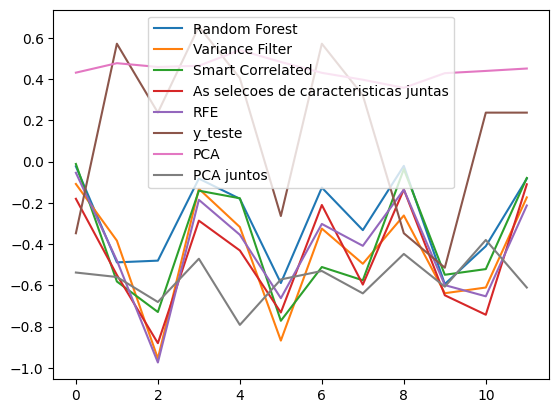

In [84]:
import matplotlib.pyplot as plt
plt.plot(y_pred, label="Random Forest")
plt.plot(y_pred_variance, label="Variance Filter")
plt.plot(y_pred_smart_correlated, label="Smart Correlated")
plt.plot(y_pred_juntos, label="As selecoes de caracteristicas juntas")
plt.plot(y_pred_rfe, label="RFE")
plt.plot(y_teste, label="y_teste")
plt.plot(y_pred_pca, label="PCA")
plt.plot(y_pred_pca_juntos, label="PCA juntos")
#plt.plot(y_pred_recursive, label="Recursive")
plt.legend()
plt.show()